# Определение возраста клиентов по фото

Сетевой супермаркет **«Хлеб-Соль»** внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# Загрузка и изучение данных

In [4]:
# импортируем библиотек для работы с датасетом и 
# исследовательского анализа
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# импортируем ProfileReport
from pandas_profiling import ProfileReport

# импортируем загрузчик изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# считываем csv-файл датасета в перемнную df
df = pd.read_csv('/datasets/faces/labels.csv')

In [6]:
# рассмотрим данные датасета (первые 5 строчек)
df.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Датасет из меток состоит из 2 столбцов: имени файла с изображением клиента и возраста клиента. Названия столбцов соответствуют стилю

In [7]:
# посмотрим основную информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропуски отсутствуют, типы данных корректны

In [8]:
# применим функцию describe
df.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

Аномальные данные отсутствуют

In [9]:
# выведем количество дубликатов в датасете
display(df.duplicated().sum())

0

Произведем загрузку данных по изображениям

In [10]:
# инициируем загрузчик изображений
datagen = ImageDataGenerator(rescale=1./255)
# применяем загрузчик к базе фотографий
image_data_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Выводы**
- изучен датасет с метками возраста базы фотографий
- база изображений состоит из 7591 фотографий
- данные по меткам не требуют предобработки. Дубликаты, аномалии, пропуски отсутствуют
- загружены данные по изображениям с помощью загрузчика

# Исследовательский анализ данных

Для изучения и описания отдельных параметров будем применять гистограммы, функцию ProfileReport() и диаграммы размаха

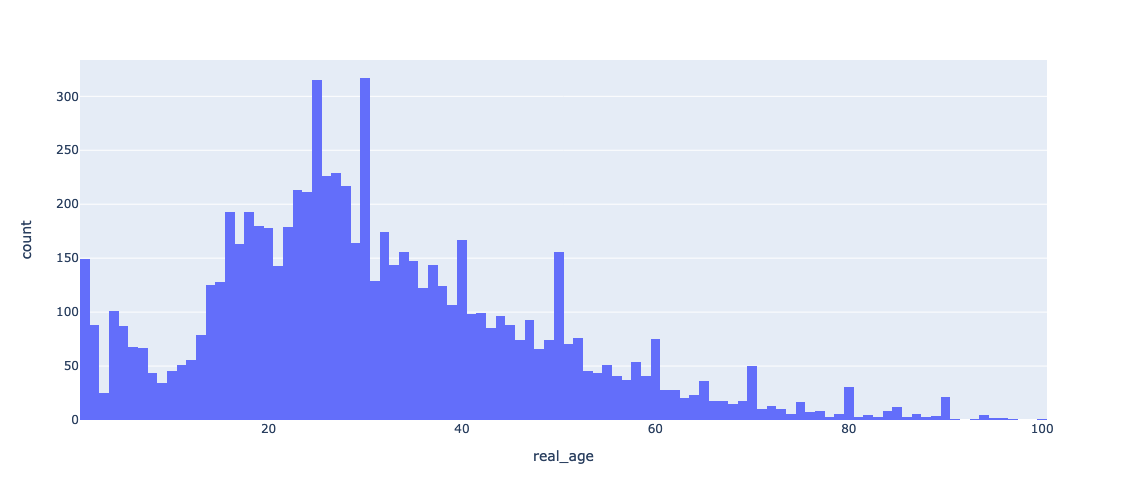

In [11]:
# построим гистограмму 
hist = px.histogram(df, x='real_age', nbins=100)
hist.update_layout(height=500)
hist.show()

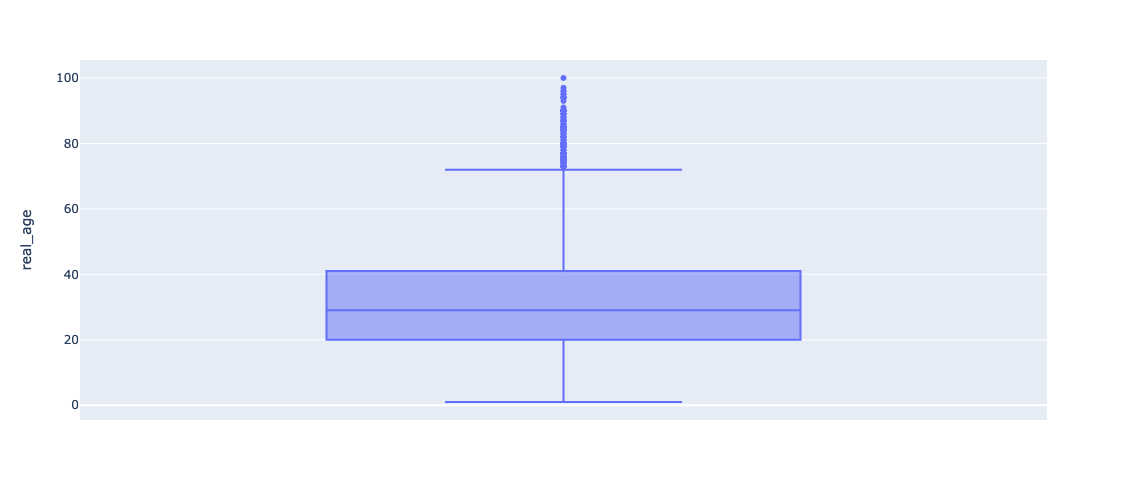

In [12]:
#построим график boxplot
fig = px.box(df, y='real_age')
fig.update_layout(height=500)
fig.show()

In [13]:
# создадим Profile Report по датасету
profile = ProfileReport(df, title="Pandas Profiling Report Data Labels")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Распечатем 16 фото клиентов с указанием их возраста

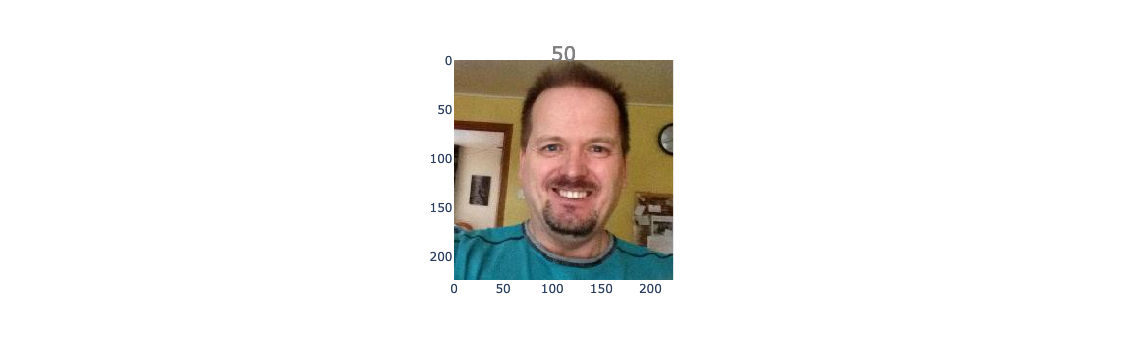

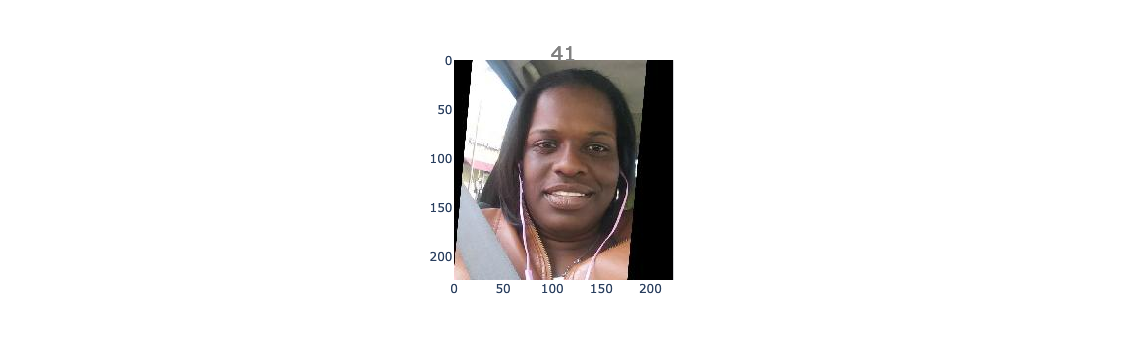

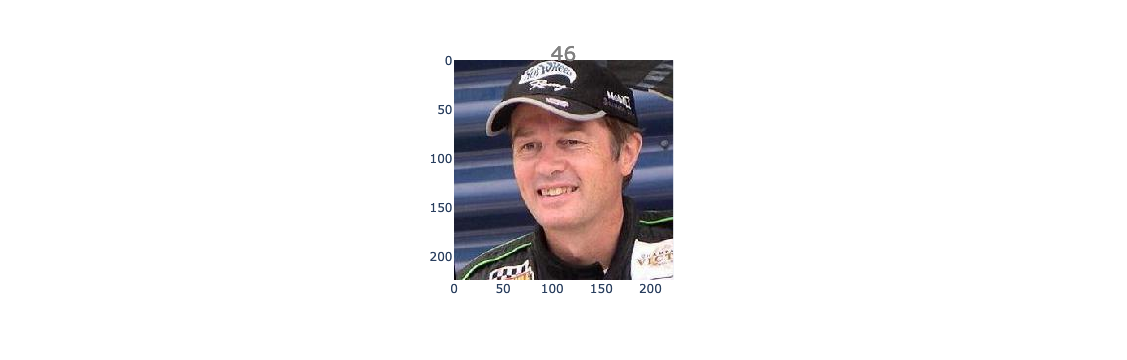

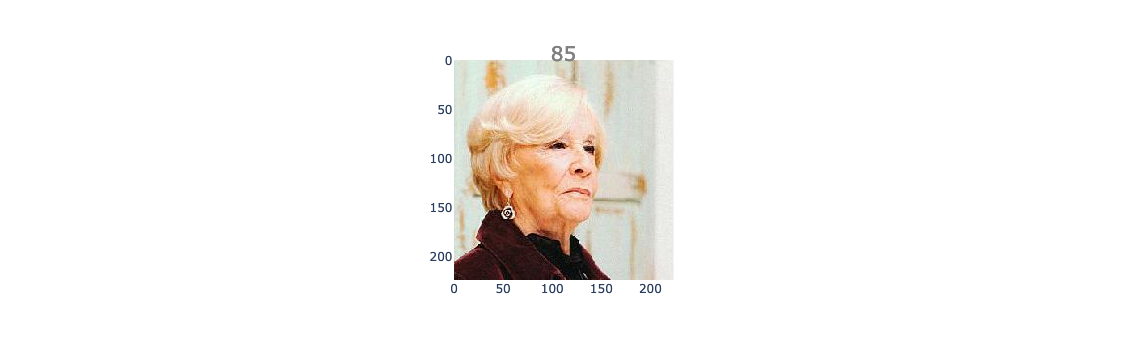

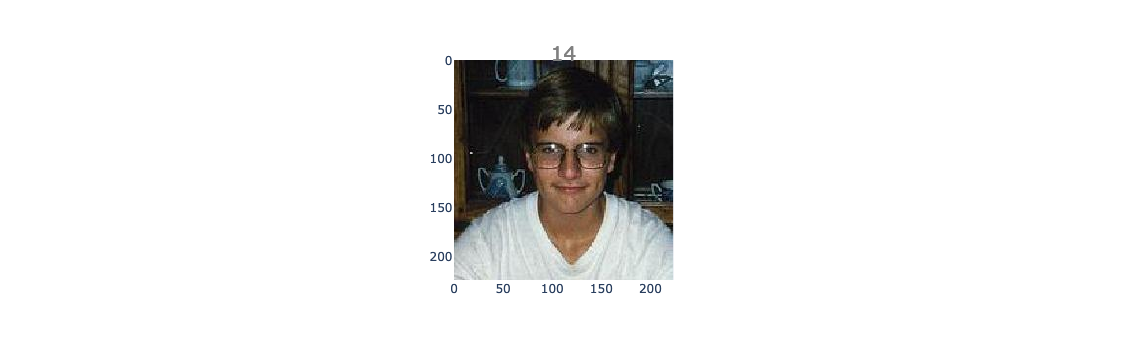

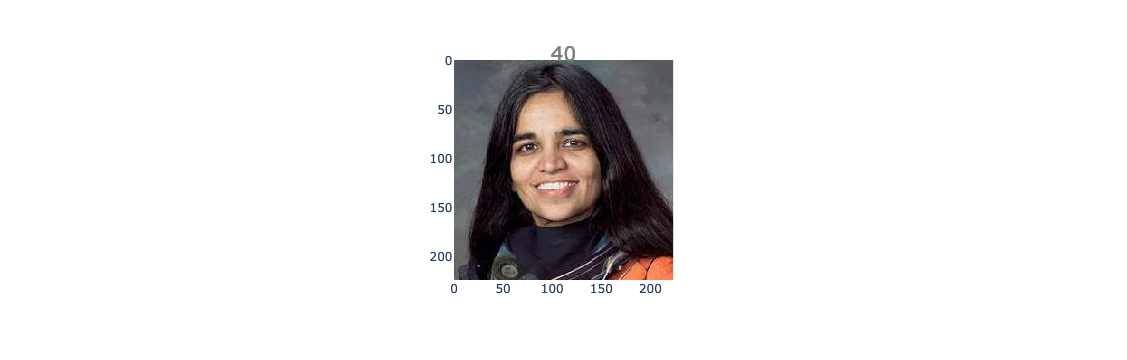

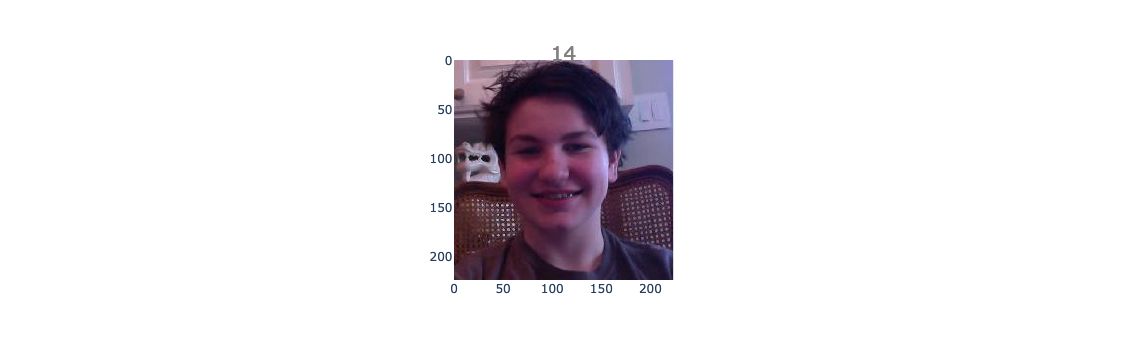

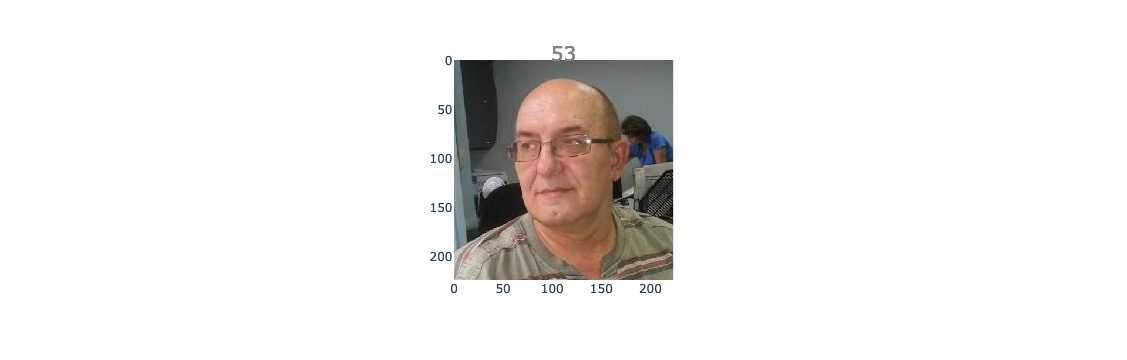

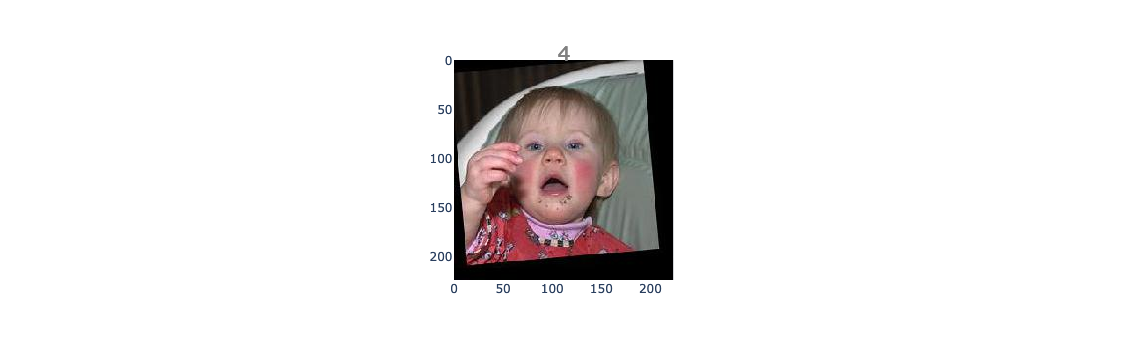

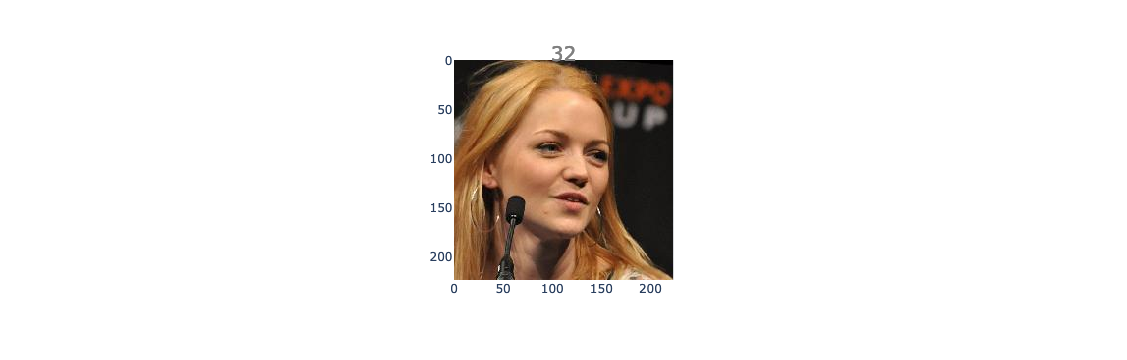

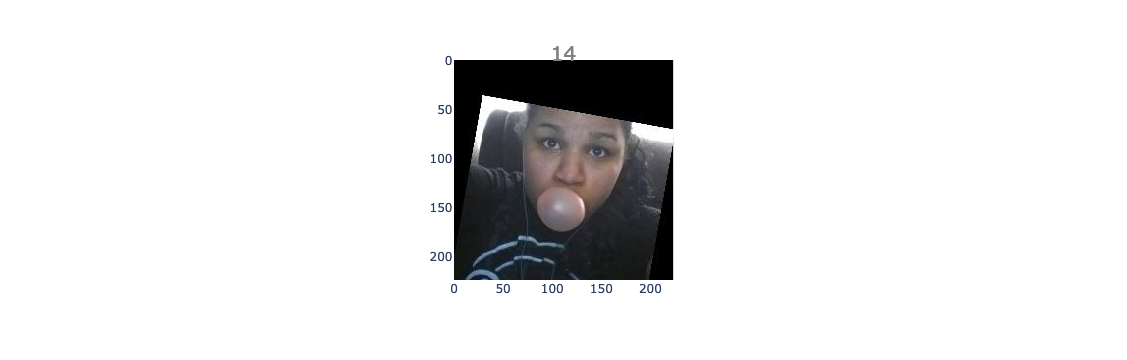

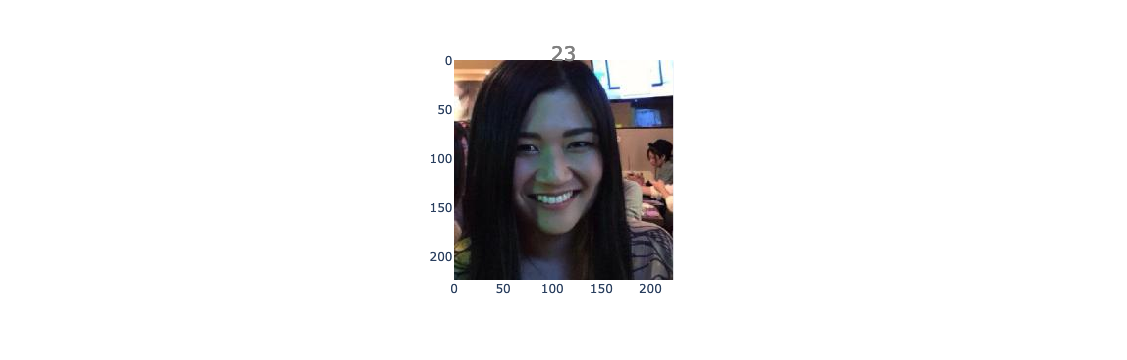

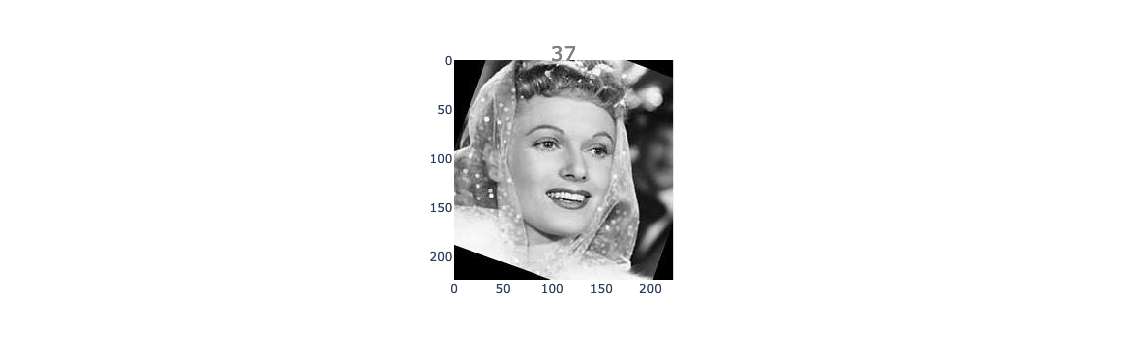

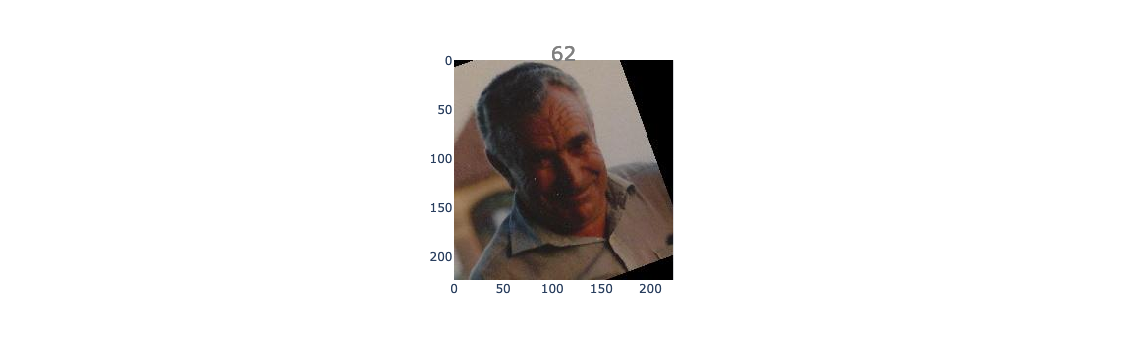

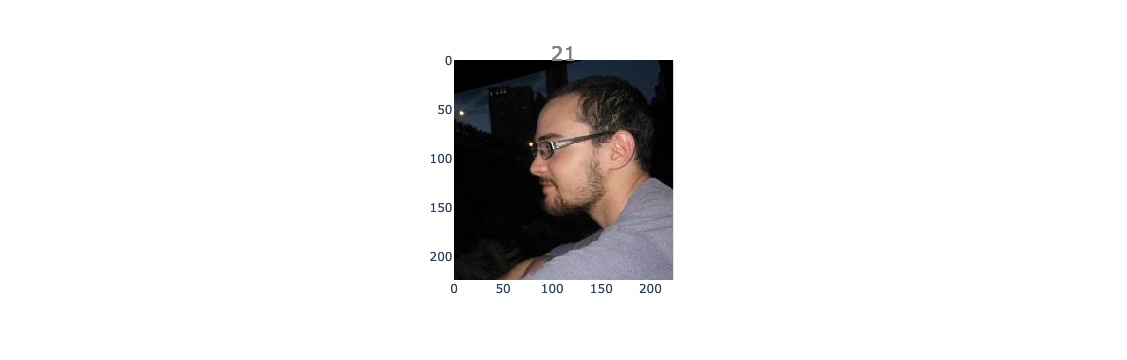

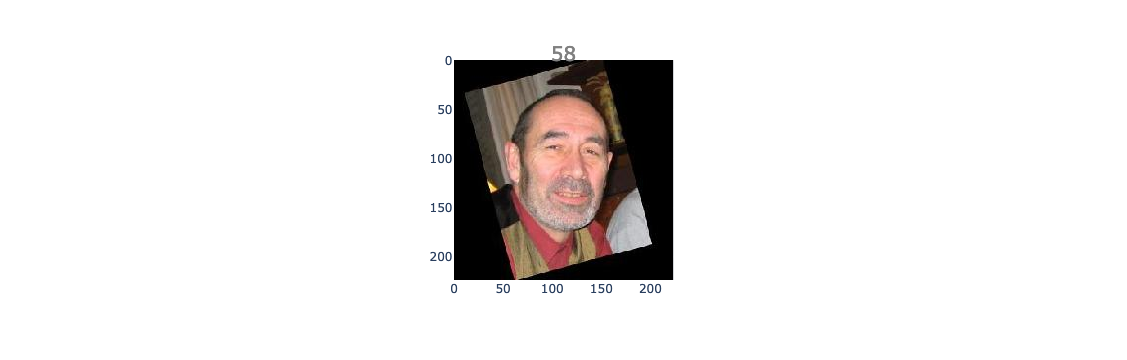

In [15]:
x, y = next(image_data_flow)
# с помощью цикла отобразим 16 фотографий
for i in range(16):
    text = y[i].astype(object)
    fig = px.imshow(x[i], binary_format="jpeg", binary_compression_level=0)
    fig.add_annotation(
        x=0.5,
        y=1.1,
        text=text,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20, font_color='grey')
    fig.show()

**Выводы**

- согласно гистограммы можно сказать, что распределение по возрасту похоже нормальное, что объясняется достаточно большим количеством клиентов, которые приходят со своими детьми до 7 лет (585 детей)
- большая часть изображений у клиентов возрастом от 20 до 40 лет
- наибольшее количество клиентов в возрасте 30 лет (317 изображений) и 25 лет (315 изображений)
- минимальный возраст клиента - 1 год, а максимальный - 100 лет
- среднее значение возраста - 31 год, а медиана равна 29 годам
- из выгружанных изображений стоит отметить, что лица находтся по центру, нормально ориентированы по горизонтали и вертикали. В некоторых фото присутствуют черные области из-за предварительной обработки изображений при их повороте
- объема базы изоражений хватает для обучения модели

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=22,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/22
2023-02-20 06:10:16.153930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-20 06:10:16.442204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 62s - loss: 185.2112 - mae: 10.2101 - val_loss: 916.8673 - val_mae: 25.4422
Epoch 2/22
356/356 - 39s - loss: 110.5700 - mae: 8.0266 - val_loss: 210.9785 - val_mae: 10.9705
Epoch 3/22
356/356 - 39s - loss: 83.3559 - mae: 6.9740 - val_loss: 115.5142 - val_mae: 8.0554
Epoch 4/22
356/356 - 39s - loss: 68.4810 - mae: 6.3397 - val_loss: 168.5665 - val_mae: 10.6165
Epoch 5/22
356/356 - 38s - loss: 52.3414 - mae: 5.5595 - val_loss: 153.4365 - val_mae: 9.5115
Epoch 6/22
356/356 - 39s - loss: 43.0759 - mae: 4.9931 - val_loss: 78.5877 - val_mae: 6.6423
Epoch 7/22
356/356 - 41s - loss: 35.4905 - mae: 4.5636 - val_loss: 90.2165 - val_mae: 7.2026
Epoch 8/22
356/356 - 55s - loss: 31.4085 - mae: 4.2823 - val_loss: 182.3169 - val_mae: 10.5282
Epoch 9/22
356/356 - 53s - loss: 29.7580 - mae: 4.1890 - val_loss: 75.9203 - val_mae: 6.5225
Epoch 10/22
356/356 - 44s - loss: 24.9310 - mae: 3.8429 - val_loss: 84.1995 - val_mae: 6.9007
Epoch 11/22
356/356 - 56s - loss: 22.9392 - mae: 3.6658 - val_loss: 90.3051 - val_mae: 7.3492
Epoch 12/22
356/356 - 49s - loss: 19.8062 - mae: 3.4254 - val_loss: 70.6970 - val_mae: 6.3452
Epoch 13/22
356/356 - 48s - loss: 19.0057 - mae: 3.3223 - val_loss: 75.2673 - val_mae: 6.6075
Epoch 14/22
356/356 - 56s - loss: 16.2433 - mae: 3.0957 - val_loss: 75.7935 - val_mae: 6.5627
Epoch 15/22
356/356 - 44s - loss: 14.7900 - mae: 2.9570 - val_loss: 70.1990 - val_mae: 6.2270
Epoch 16/22
356/356 - 54s - loss: 13.6324 - mae: 2.8324 - val_loss: 75.9428 - val_mae: 6.4708
Epoch 17/22
356/356 - 56s - loss: 13.8548 - mae: 2.8524 - val_loss: 73.1310 - val_mae: 6.5791
Epoch 18/22
356/356 - 43s - loss: 15.4216 - mae: 3.0086 - val_loss: 70.0168 - val_mae: 6.3024
Epoch 19/22
356/356 - 55s - loss: 16.4790 - mae: 3.0968 - val_loss: 79.0357 - val_mae: 6.8789
Epoch 20/22
356/356 - 51s - loss: 17.2540 - mae: 3.1642 - val_loss: 74.3254 - val_mae: 6.4402
Epoch 21/22
356/356 - 47s - loss: 14.3240 - mae: 2.9183 - val_loss: 72.4459 - val_mae: 6.2843
Epoch 22/22
356/356 - 56s - loss: 11.9486 - mae: 2.6478 - val_loss: 69.7233 - val_mae: 6.1689
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 69.7233 - mae: 6.1689
Test MAE: 6.1689

```

## Анализ обученной модели

Для обучения модели использовали архитектуру ResNet50 с предобученной моделью (параметр `imagenet`). Использовалась аугментация `horizontal_flip`, функция активации `RELU`.

Я обучил четыре модели:
Лучшие параметры были получены при `learning rate=0.0003` и `22 эпохи` что дало показатель MAE около 6.1689. Ни в одной испробованной модели переобучения не было.
Также использовал ряд других параметров, который отразил в таблице:

In [16]:
results = {'learning rate': [0.01, 0.001, 0.0005, 0.0003], 
           'epochs': [10, 20, 20, 22],
           'MAE': [12.3226, 7.7240, 7.4825, 6.189],
          }
results = pd.DataFrame(data=results)
results

learning rate  epochs      MAE
0         0.0100      10  12.3226
1         0.0010      20   7.7240
2         0.0005      20   7.4825
3         0.0003      22   6.1890